Epoch 1 completed with loss: -7.450580707946131e-10
Epoch 2 completed with loss: -2.9853730666218325e-05
Epoch 3 completed with loss: -5.976557804387994e-05
Epoch 4 completed with loss: -9.015276737045497e-05
Epoch 5 completed with loss: -0.00011957809329032898
Epoch 6 completed with loss: -0.0001500532089266926
Epoch 7 completed with loss: -0.00017997770919464529
Epoch 8 completed with loss: -0.00021101682796142995
Epoch 9 completed with loss: -0.0002409063308732584
Epoch 10 completed with loss: -0.0002727670653257519


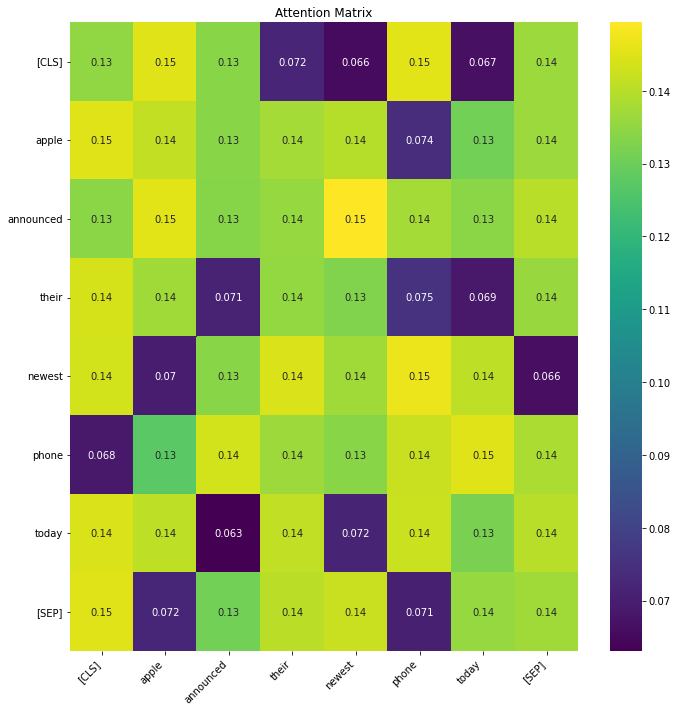

In [18]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertConfig, AdamW
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define a small dataset
class SmallDataset(Dataset):
    def __init__(self, sentences, tokenizer, max_len):
        self.sentences = sentences
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, index):
        sentence = self.sentences[index]
        encoding = self.tokenizer.encode_plus(
            sentence,
            max_length=self.max_len,
            add_special_tokens=True,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

# Small dataset
sentences = [
    "Apple announced their newest phone today",
    "I love to eat a juicy apple pie"
]

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create dataset and dataloader
max_len = 10
dataset = SmallDataset(sentences, tokenizer, max_len)
dataloader = DataLoader(dataset, batch_size=2)

# Initialize a simple BERT model with attention outputs enabled
config = BertConfig(
    hidden_size=128, 
    num_attention_heads=2, 
    num_hidden_layers=2, 
    intermediate_size=256,
    output_attentions=True  # Enable output attentions
)
model = BertModel(config)

# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Training loop
epochs = 10
for epoch in range(epochs):
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = torch.mean(outputs.last_hidden_state)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} completed with loss: {loss.item()}")

def plot_attention_matrix(attention, tokens):
    # Calculate the mean of the attention weights across all attention heads
    attention = attention.mean(dim=1).squeeze(0).detach().numpy()
    
    # Create a plot
    fig, ax = plt.subplots(figsize=(10, 10))  # Increased figure size for better visibility
    
    # Generate a heatmap
    heatmap = sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, cmap='viridis', ax=ax, annot=True)
    
    # Set the title of the heatmap
    ax.set_title('Attention Matrix')
    
    # Rotate tick labels for better visibility
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Adjust layout to make room for token labels
    plt.tight_layout()
    
    # Display the plot
    plt.show()

# Get attention weights from the model
input_ids = tokenizer(sentences[0], return_tensors='pt')['input_ids']
with torch.no_grad():
    outputs = model(input_ids)
    attention = outputs.attentions[0]  # Get attention weights for the first layer

# Tokenize the first sentence and plot the attention matrix
tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze())
plot_attention_matrix(attention, tokens)


In [19]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load pre-trained model and tokenizer
model_name = 'gpt2'
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Encode input text
input_text = "Once upon a time"
input_ids = tokenizer.encode(input_text, return_tensors='pt')

# Generate text
output = model.generate(input_ids, max_length=50, num_return_sequences=1)

# Decode and print the output
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Once upon a time, the world was a place of great beauty and great danger. The world was a place of great danger, and the world was a place of great danger. The world was a place of great danger, and the world was a


In [23]:
from transformers import BertForMaskedLM, BertTokenizer
import torch

# Load pre-trained model and tokenizer
model_name = 'bert-base-uncased'
model = BertForMaskedLM.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)
model.eval()  # Set the model to evaluation mode

# Encode input text with a masked token
input_text = "Once upon a [MASK] there was a kingdom."
input_ids = tokenizer(input_text, return_tensors='pt')['input_ids']

# Predict the masked token
with torch.no_grad():  # Disable gradient calculation for inference
    outputs = model(input_ids)
    predictions = outputs.logits

# Get the index of the masked token
mask_token_index = torch.where(input_ids == tokenizer.mask_token_id)[1]

# Get the predicted token at the masked position
predicted_index = torch.argmax(predictions[0, mask_token_index.item()], axis=-1)
predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]

# Replace the mask with the predicted token and print the output
output_text = input_text.replace("[MASK]", predicted_token)
print(output_text)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Once upon a time there was a kingdom.


In [24]:
from transformers import BartForConditionalGeneration, BartTokenizer
import torch

# Load pre-trained model and tokenizer
model_name = 'facebook/bart-large'
model = BartForConditionalGeneration.from_pretrained(model_name)
tokenizer = BartTokenizer.from_pretrained(model_name)
model.eval()  # Set the model to evaluation mode

# Prepare an input prompt
input_text = "Once upon a time in a far away land,"
input_ids = tokenizer(input_text, return_tensors='pt')['input_ids']

# Generate a continuation of the input text
output_ids = model.generate(
    input_ids,
    max_length=50,   # Specify the maximum length of the generated text
    num_beams=5,     # Use beam search with 5 beams
    no_repeat_ngram_size=2,  # Prevent repeating 2-grams
    early_stopping=True     # Stop generating when all beam hypotheses reach the EOS token
)

# Decode and print the generated text
generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(generated_text)


Once upon a time in a far away land,


In [25]:
from transformers import BartForConditionalGeneration, BartTokenizer
import torch

# Load pre-trained model and tokenizer
model_name = 'facebook/bart-large-cnn'  # This checkpoint is optimized for summarization.
model = BartForConditionalGeneration.from_pretrained(model_name)
tokenizer = BartTokenizer.from_pretrained(model_name)
model.eval()  # Set the model to evaluation mode

# Input text for summarization
input_text = """
The Amazon rainforest, also known in English as Amazonia or the Amazon Jungle, 
is a moist broadleaf tropical rainforest in the Amazon biome that covers most of 
the Amazon basin of South America. This basin encompasses 7,000,000 square kilometers 
(2,700,000 sq mi), of which 5,500,000 square kilometers (2,100,000 sq mi) are covered by 
the rainforest. This region includes territory belonging to nine nations and is known 
for being the largest tropical rainforest in the world. It is often described as the 
"Lungs of the Earth" because it produces more than 20% of the world's oxygen.
"""

# Encode the input text
input_ids = tokenizer(input_text, return_tensors='pt')['input_ids']

# Generate a summary of the input text
output_ids = model.generate(
    input_ids,
    max_length=100,  # Reasonable maximum length for a summary
    num_beams=4,     # Use beam search with 4 beams for better quality
    length_penalty=2.0,  # Encourage shorter summaries
    no_repeat_ngram_size=3,  # Prevent repeating 3-grams to ensure diversity
    early_stopping=True  # Stop when the summary is complete
)

# Decode and print the generated summary
generated_summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(generated_summary)


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Error while downloading from https://cdn-lfs.huggingface.co/facebook/bart-large-cnn/40041830399afb5348525ef8354b007ecec4286fdf3524f7e6b54377e17096cb?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1715918769&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxNTkxODc2OX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9mYWNlYm9vay9iYXJ0LWxhcmdlLWNubi80MDA0MTgzMDM5OWFmYjUzNDg1MjVlZjgzNTRiMDA3ZWNlYzQyODZmZGYzNTI0ZjdlNmI1NDM3N2UxNzA5NmNiP3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiJ9XX0_&Signature=TPFpYNWIB8BAz9nXNp-OFdq8g77j7EzQe6MSSYjpi3kHqAKZ%7EwXwYMWL9wOXrfUpzjgm1tRXONFpqNPOcQvSENUW-O8XljhwkFyQmH3zUOu-aQzy58VPLyK2x3S8HOXeuxu5bwXmYTm1iOfL5HmQer1YPNNhAGQERRR62KCSLkzP6l4P%7EJBlNNfHwB7xMZ5irNOySELmpEY6DxYBvc9HFJ-q9Y12NsjLYeM9Dmxghn5%7EeVnSsMTuIK4xDf2ctCOkMvmnui3vbAxXmpqqLnD4yHyPh1tXMyoc7wPePbMWCGAEOWJaAYUFi0lma7QSW0NH%7ERUlOI0RxShKZD1FyQgqIA__&Key-Pair-Id=KVTP

model.safetensors:  77%|#######6  | 1.25G/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

The Amazon rainforest is the largest tropical rainforest in the world. It is often described as the "Lungs of the Earth" because it produces more than 20% of the world's oxygen. It covers 7,000,000 square kilometers (2,700,000 sq mi) of South America.
